In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/train

Mounted at /gdrive
/gdrive/My Drive/train


In [2]:
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
import sklearn
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools



SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
from sklearn.model_selection import train_test_split
import os
import re

In [4]:
path_to_data = "/gdrive/My Drive/train"

In [5]:
def load_data(file):

  original = loadmat(file) #  dictionary with variable names as keys, and loaded matrices as values

  spk_file = file.replace('.mat', '_spk.mat')
  spk = loadmat(spk_file)

  ann_file = file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)

  return original, spk, ann

In [6]:
def filter_files_by_pattern(directory, pattern):
    """
    Filter files in a directory based on a specified pattern.

    Parameters:
    - directory: The directory containing the files.
    - pattern: The regular expression pattern to match filenames.

    Returns:
    - List of filenames matching the pattern.
    """
    files = os.listdir(directory)
    filtered_files = [file for file in files if re.match(pattern, file)]
    return filtered_files

In [7]:
directory = path_to_data
pattern = r'S\d{3}_\d{3}\.mat'  # Regular expression pattern matching 'SXXX_YYY.mat'

filtered_files = filter_files_by_pattern(directory, pattern)
print(filtered_files)

['S120_250.mat', 'S114_250.mat', 'S116_250.mat', 'S109_250.mat', 'S115_250.mat', 'S117_250.mat', 'S119_250.mat', 'S110_250.mat', 'S113_250.mat', 'S102_250.mat', 'S108_250.mat', 'S121_250.mat', 'S106_250.mat', 'S112_250.mat', 'S111_250.mat', 'S095_250.mat', 'S084_250.mat', 'S088_250.mat', 'S099_250.mat', 'S118_250.mat', 'S098_250.mat', 'S091_250.mat', 'S097_250.mat', 'S103_250.mat', 'S093_250.mat', 'S105_250.mat', 'S101_250.mat', 'S094_250.mat', 'S087_250.mat', 'S100_250.mat', 'S096_250.mat', 'S104_250.mat', 'S092_250.mat', 'S042_128.mat', 'S062_128.mat', 'S057_128.mat', 'S055_128.mat', 'S053_128.mat', 'S081_250.mat', 'S051_128.mat', 'S080_250.mat', 'S052_128.mat', 'S060_128.mat', 'S089_250.mat', 'S059_128.mat', 'S061_128.mat', 'S085_250.mat', 'S044_128.mat', 'S090_250.mat', 'S054_128.mat', 'S082_250.mat', 'S083_250.mat', 'S058_128.mat', 'S049_128.mat', 'S086_250.mat', 'S046_128.mat', 'S048_128.mat', 'S041_128.mat', 'S039_128.mat', 'S079_250.mat', 'S043_128.mat', 'S021_128.mat', 'S024_1

In [8]:
train_files = filtered_files[:round(len(filtered_files)*0.8)]

In [9]:
train_files

['S120_250.mat',
 'S114_250.mat',
 'S116_250.mat',
 'S109_250.mat',
 'S115_250.mat',
 'S117_250.mat',
 'S119_250.mat',
 'S110_250.mat',
 'S113_250.mat',
 'S102_250.mat',
 'S108_250.mat',
 'S121_250.mat',
 'S106_250.mat',
 'S112_250.mat',
 'S111_250.mat',
 'S095_250.mat',
 'S084_250.mat',
 'S088_250.mat',
 'S099_250.mat',
 'S118_250.mat',
 'S098_250.mat',
 'S091_250.mat',
 'S097_250.mat',
 'S103_250.mat',
 'S093_250.mat',
 'S105_250.mat',
 'S101_250.mat',
 'S094_250.mat',
 'S087_250.mat',
 'S100_250.mat',
 'S096_250.mat',
 'S104_250.mat',
 'S092_250.mat',
 'S042_128.mat',
 'S062_128.mat',
 'S057_128.mat',
 'S055_128.mat',
 'S053_128.mat',
 'S081_250.mat',
 'S051_128.mat',
 'S080_250.mat',
 'S052_128.mat',
 'S060_128.mat',
 'S089_250.mat',
 'S059_128.mat',
 'S061_128.mat',
 'S085_250.mat',
 'S044_128.mat',
 'S090_250.mat',
 'S054_128.mat',
 'S082_250.mat',
 'S083_250.mat',
 'S058_128.mat',
 'S049_128.mat',
 'S086_250.mat',
 'S046_128.mat',
 'S048_128.mat',
 'S041_128.mat',
 'S039_128.mat

In [10]:
validation_files = filtered_files[(round(len(filtered_files)*0.8)):]

In [11]:
validation_files

['S027_128.mat',
 'S035_128.mat',
 'S032_128.mat',
 'S015_128.mat',
 'S022_128.mat',
 'S016_128.mat',
 'S017_128.mat',
 'S007_128.mat',
 'S005_128.mat',
 'S004_128.mat',
 'S001_128.mat',
 'S008_128.mat',
 'S009_128.mat',
 'S011_128.mat',
 'S002_128.mat',
 'S013_128.mat',
 'S033_128.mat',
 'S056_128.mat',
 'S006_128.mat',
 'S012_128.mat',
 'S003_128.mat']

In [12]:
train = []
ecg_train = []
spk_train = []
ann_train = []

for file in train_files:
  ecg, spk, ann = load_data(path_to_data + '/' + file)
  ecg_train.append(ecg)
  spk_train.append(spk)
  ann_train.append(ann)

  train.append(path_to_data + '/' + file)

In [13]:
validation = []
ecg_validation = []
spk_validation = []
ann_validation = []

for file in validation_files:

  ecg, spk, ann = load_data(path_to_data + '/' + file)
  ecg_validation.append(ecg)
  spk_validation.append(spk)
  ann_validation.append(ann)

  validation.append(path_to_data + '/' + file)

In [14]:
! pip install neurokit2 tdqm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=9c3a784ede6ec6ba5a7b8c023d1426c90481e35e8907d88c4e5b0f128e9d1fcb
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [15]:
def freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

(-5.0, 5.0)

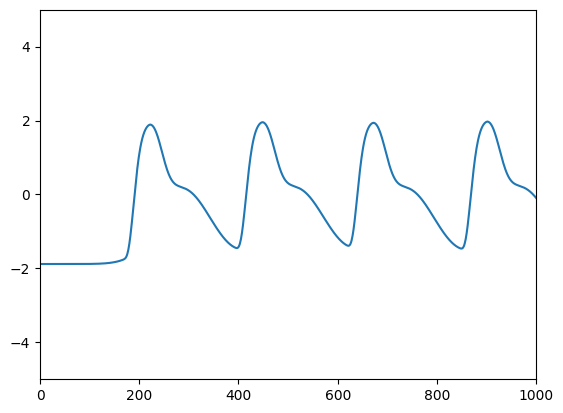

In [16]:

import matplotlib.pyplot as plt

# plot a piece of one ECG signal
plt.plot(ecg_train[1]['ppg'][:,0])
plt.xlim(0,1000)
plt.ylim(-5,5)

In [17]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [18]:
import scipy

In [19]:
# Resample to 250 Hz training ECG signals

resampled_ecg_1_train = []

for i in range(len(ecg_train)):
   secs_1 = len(ecg_train[i]['ppg'][:,0])/ecg_freq(train[i]) # Number of seconds in signal X
   samps_1 = secs_1*250     # Number of samples to downsample
   resampled_ecg_1_train.append(scipy.signal.resample(ecg_train[i]['ppg'][:,0] , int(samps_1)))

In [20]:

# Resample to 250 Hz validation ECG signals

resampled_ecg_1_validation = []

for i in range(len(ecg_validation)):
   secs_1 = len(ecg_validation[i]['ppg'][:,0])/ecg_freq(validation[i]) # Number of seconds in signal X
   samps_1 = secs_1*250     # Number of samples to downsample
   resampled_ecg_1_validation.append(scipy.signal.resample(ecg_validation[i]['ppg'][:,0] , int(samps_1)))

250

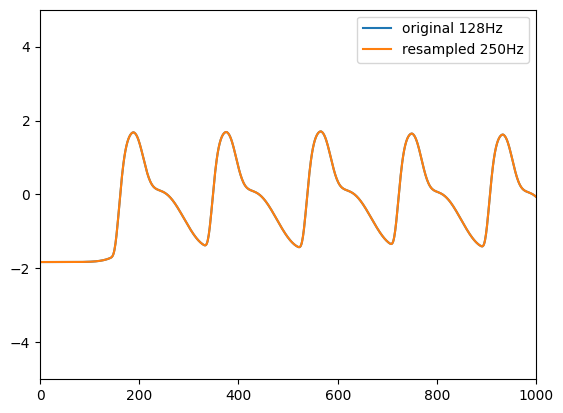

In [21]:
# look the effect of signal resampling
beat = 50
plt.plot(ecg_train[beat]['ppg'][:,0])
plt.plot(resampled_ecg_1_train[beat])
plt.legend(['original 128Hz', 'resampled 250Hz'])
plt.xlim(0, 1000)
plt.ylim(-5,5)

ecg_freq(train[beat])

In [22]:
# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = scipy.signal.firwin(12, 35/125, fs = 250)

In [23]:
len(resampled_ecg_1_train)

84

In [24]:
len(resampled_ecg_1_validation)

21

In [25]:
mf600 = int(250 * 0.6) - 1
mf200 = int(250 * 0.2) - 1
for i in range(len(resampled_ecg_1_train)):
  resampled_ecg_1_train[i] = scipy.signal.lfilter(taps, 1.0, resampled_ecg_1_train[i] - scipy.signal.medfilt(scipy.signal.medfilt(resampled_ecg_1_train[i], mf200), mf600))



for i in range(len(resampled_ecg_1_validation)):
  resampled_ecg_1_validation[i] = scipy.signal.lfilter(taps, 1.0, resampled_ecg_1_validation[i] - scipy.signal.medfilt(scipy.signal.medfilt(resampled_ecg_1_validation[i], mf200), mf600))


250

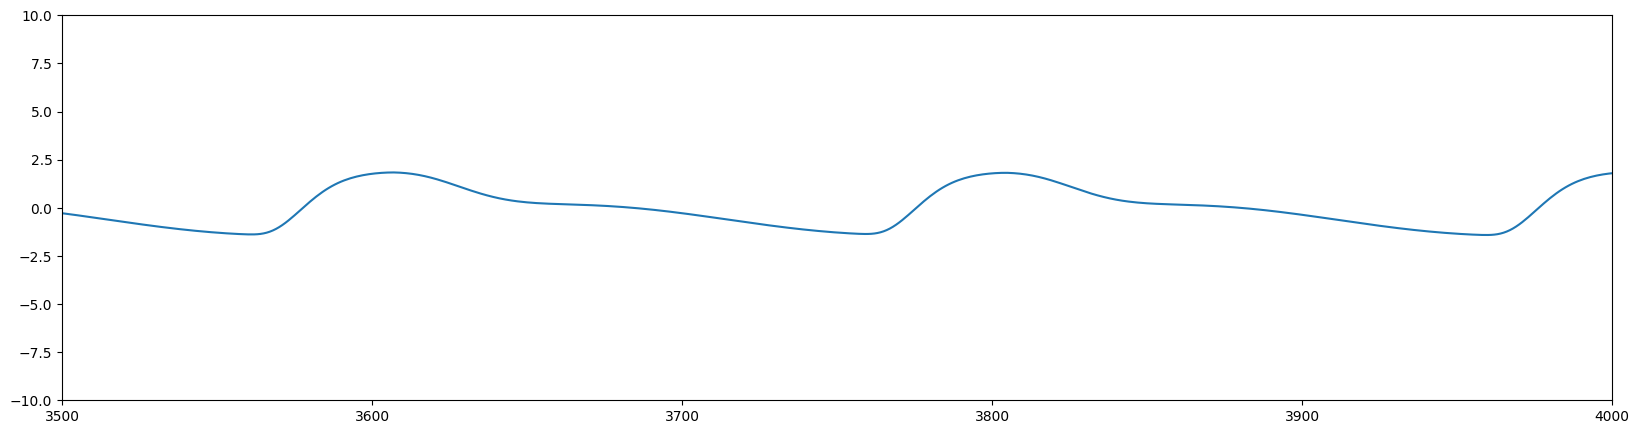

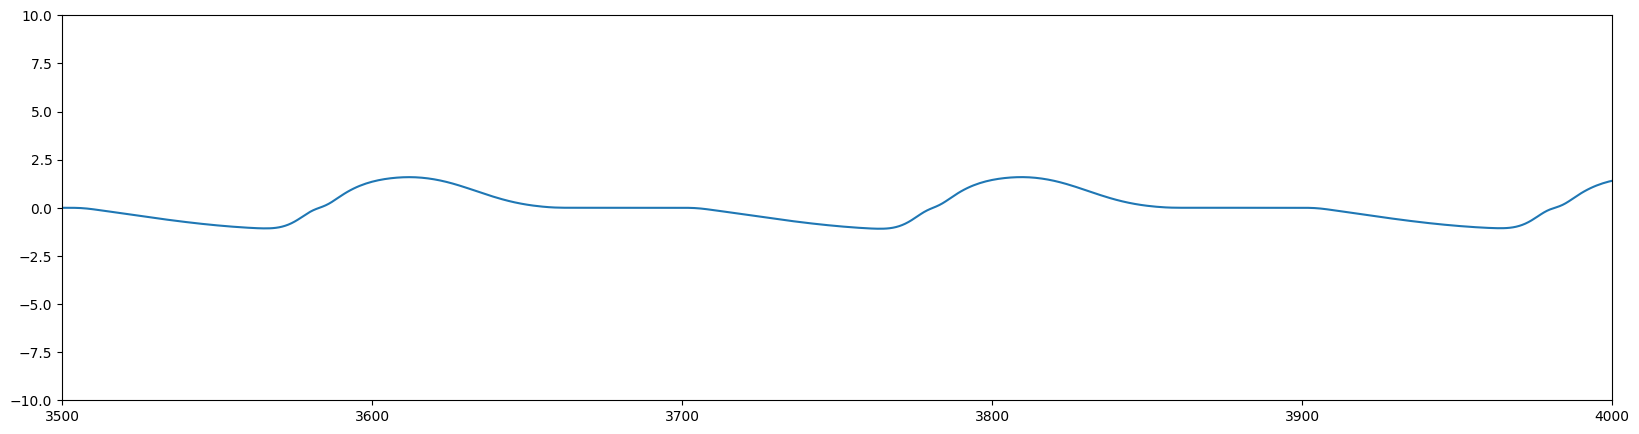

In [26]:
# plot the effect of the denoising procedure showing a piece of ECG before and after the applications of filters

x = 50
plt.figure(figsize=(20, 5))
plt.plot(ecg_train[x]['ppg'][:,0])
plt.xlim(3500, 4000)
plt.ylim(-10,10)
plt.figure(figsize=(20, 5))
plt.plot(resampled_ecg_1_train[x])
plt.xlim(3500, 4000)
plt.ylim(-10,10)
ecg_freq(train[x])


In [27]:
spk_train[0]['speaks']

array([[   211],
       [   430],
       [   633],
       ...,
       [449512],
       [449709],
       [449911]], dtype=int32)

In [28]:
spk_train[1]['speaks']

array([[   223],
       [   450],
       [   674],
       ...,
       [449307],
       [449541],
       [449769]], dtype=int32)

In [29]:
def from_freq_to_freq(sample, ini_freq, freq = 250):
   secs = sample/ini_freq # Number of seconds in signal X
   samp = secs*freq       # Number of samples to downsample
   return int(samp)

In [30]:
# This parameter is the number of samples considered to segment the ECG signal (the segment will be the samples of current R peak +/- win)
win = 250

In [31]:
# Extract all the segments (single heartbeats) from the original raw signals

heartbeats_train_1 = []
heartbeats_validation_1 = []

for i in range(len(ecg_train)):
  for j in range(len(spk_train[i]['speaks'])):
   if(from_freq_to_freq(spk_train[i]['speaks'][j],ecg_freq(train[i])) < win or from_freq_to_freq(spk_train[i]['speaks'][j],ecg_freq(train[i]))  + win > from_freq_to_freq(spk_train[i]['speaks'][-1],ecg_freq(train[i])) or j < 40 or (len(spk_train[i]['speaks']) - (j+1) < 40)): #skipping beats that are too much close to the initial and to the end of the signal
    ann_train[i]['labels'][j] = 'A'
    spk_train[i]['speaks'][j] = 0
   else:
    heartbeats_train_1.append(resampled_ecg_1_train[i][from_freq_to_freq(spk_train[i]['speaks'][j],ecg_freq(train[i]))  - win : from_freq_to_freq(spk_train[i]['speaks'][j],ecg_freq(train[i]))  + win])
    #heartbeats_train_2.append(resampled_ecg_2_train[i][from_freq_to_freq(rpks_train[i]['rpeaks'][j],ecg_freq(filenames_train[i]))  - win : from_freq_to_freq(rpks_train[i]['rpeaks'][j],ecg_freq(filenames_train[i]))  + win])

for i in range(len(ecg_validation)):
  for j in range(len(spk_validation[i]['speaks'])):
   if(from_freq_to_freq(spk_validation[i]['speaks'][j],ecg_freq(validation[i])) < win or from_freq_to_freq(spk_validation[i]['speaks'][j],ecg_freq(validation[i])) + win > from_freq_to_freq(spk_validation[i]['speaks'][-1],ecg_freq(validation[i]))): #skipping beats that are too much close to the initial and to the end of the signal
    ann_validation[i]['labels'][j] = 'A'
    spk_validation[i]['speaks'][j] = 0
   else:
    heartbeats_validation_1.append(resampled_ecg_1_validation[i][from_freq_to_freq(spk_validation[i]['speaks'][j],ecg_freq(validation[i]))  - win : from_freq_to_freq(spk_validation[i]['speaks'][j],ecg_freq(validation[i]))  + win])
    #heartbeats_validation_2.append(resampled_ecg_2_validation[i][from_freq_to_freq(rpks_validation[i]['rpeaks'][j],ecg_freq(filenames_validation[i]))  - win : from_freq_to_freq(rpks_validation[i]['rpeaks'][j],ecg_freq(filenames_validation[i]))  + win])


<ipython-input-29-ead6d838464d>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(samp)


In [32]:
len(spk_train[0]['speaks']), len(np.delete(spk_train[0]['speaks'], 0))

(1890, 1889)

In [33]:
len(heartbeats_train_1), len(heartbeats_validation_1)

(191472, 48365)

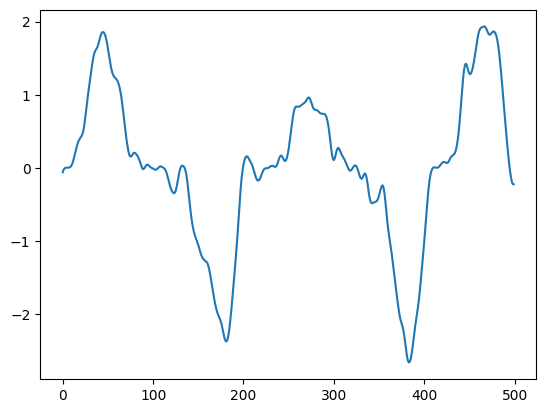

In [34]:
import matplotlib.pyplot as plt

# plot an example of segment
plt.plot(heartbeats_train_1[100])

In [35]:
labels_train = []
labels_validation = []

for i in range(len(ecg_train)):
  for j in range(len(ann_train[i]['labels'])):
    if(ann_train[i]['labels'][j] != 'A'):
     labels_train.append(ann_train[i]['labels'][j])

for i in range(len(ecg_validation)):
  for j in range(len(ann_validation[i]['labels'])):
    if(ann_validation[i]['labels'][j] != 'A'):
     labels_validation.append(ann_validation[i]['labels'][j])


In [36]:
classes_name = ['N', 'S', 'V']

In [37]:
len(labels_train), len(heartbeats_train_1)

(191472, 191472)

In [38]:
len(labels_validation), len(heartbeats_validation_1)

(48365, 48365)

In [39]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe_train = ohe.fit_transform(integer_encoded)

integer_encoded = label_encoder.fit_transform(labels_validation)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe_validation = ohe.fit_transform(integer_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [40]:
label_encoder.inverse_transform([0,1,2])

array(['N', 'S', 'V'], dtype='<U1')

In [41]:
ohe.inverse_transform([[1, 0, 0], [0,1,0], [0,0,1]])

array([[0],
       [1],
       [2]])

In [42]:
y_train = target_ohe_train
y_val = target_ohe_validation

In [43]:
X_train_1 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_train_1, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
#X_train_2 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_train_2, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
X_val_1 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_validation_1, maxlen=win * 2, dtype='float32', truncating='post',padding="post")
#X_val_2 = tf.keras.preprocessing.sequence.pad_sequences(heartbeats_validation_2, maxlen=win * 2, dtype='float32', truncating='post',padding="post")


In [44]:
y_train.shape

(191472, 3)

In [45]:
y_val.shape

(48365, 3)

In [46]:
X_train_1.shape

(191472, 500)

In [47]:
X_val_1.shape

(48365, 500)

In [48]:
X_train = []
for i in range(len(X_train_1)):
  X_train.append(X_train_1[i])

X_train = np.asarray(X_train)

In [49]:

X_val = []
for i in range(len(X_val_1)):
  X_val.append(X_val_1[i])

X_val = np.asarray(X_val)

(191472, 500)

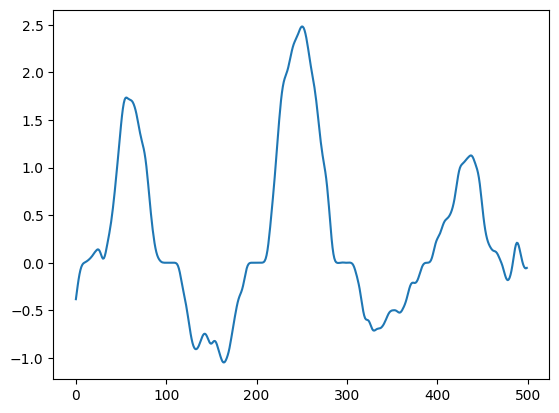

In [50]:
plt.plot(X_train[900])

X_train.shape


In [65]:
X_train = np.asarray(X_train_1)
X_val = np.asarray(X_val_1)
mean = np.mean(X_train, axis=1).mean(axis=0)
std = np.std(X_train, axis=1).mean(axis=0)
mean , std

(0.05529339, 2.472267)

In [62]:
# Normalize data (used for resnet, not for vgg)
#mean = np.mean(X_train, axis=1).mean(axis=0)
#std = np.std(X_train, axis=1).mean(axis=0)

#X_train = (X_train - mean)/std
#X_val = (X_val - mean)/std

#mean, std

(-2.0321462e-09, 0.99999994)

In [66]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

mean, std


(0.05529349, 5.7206445)

In [67]:
mean = np.mean(X_train)
std = np.std(X_train)
mean, std

(-1.680338e-08, 1.0000002)

In [68]:
len(X_train), len(X_train > 3)

(191472, 191472)

'N'

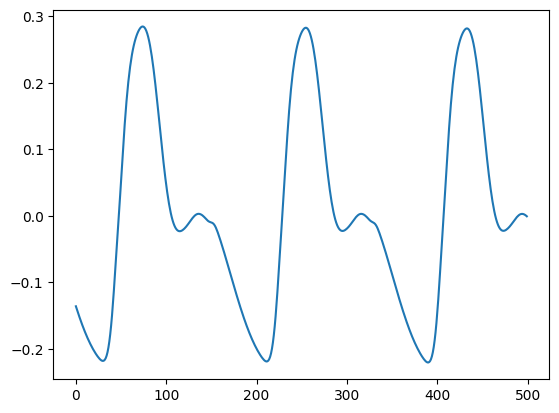

In [69]:
import matplotlib.pyplot as plt

beat = 10000
plt.plot(X_train[beat])
labels_train[beat]


In [70]:
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])

(177836, 7660, 5976)

In [71]:
import sklearn
X_train, y_train = sklearn.utils.shuffle(X_train, y_train)


In [72]:
# Considering class imbalance: class weightning to reduce the bias in the dataset

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers
                                    )

class_weights = dict(zip(np.unique(y_integers), class_weights))
class_weights


{0: 0.3588924627184597, 1: 8.332114882506527, 2: 10.680053547523427}

In [73]:
X_train.shape, y_train.shape

((191472, 500), (191472, 3))

In [74]:
#class weights for validation set
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_val, axis=1)

class_weights_val = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers
                                    )

In [75]:
class_weights_val

array([0.36057495, 8.75226203, 8.89716703])

In [76]:
decode = dict(N =  0, S = 1, V  = 2)

In [77]:
X_train.shape

(191472, 500)

In [78]:
samples_class_weights = []
for y in y_val:
  samples_class_weights.append(class_weights_val[ohe.inverse_transform([y])[0][0]])

In [79]:
# Here we load validation data, training data can be loaded with the batch generator below

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val, samples_class_weights))


In [80]:
len(train_data)


191472

In [81]:
len(validation_data)

48365

In [83]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

#utility to plot confusion matrix and evaluation metrics
def evaluate_on_valid(model, batch_size, valid_to_use):
  #Computing the prediction of the model on the validation set
  predictions = []
  for element in valid_to_use.batch(batch_size).as_numpy_iterator():
      predictions.append(model.predict(element[0]))

  predictions_f = [item for sublist in predictions for item in sublist]

  predictions_oh = []
  #transform prediction into one-hot-encoding
  for i in range(len(predictions_f)):
      predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

  #Compute the true and prediction array in order to plot the confusion matrix
  y = []

  for y_t in y_val.tolist():
      if(y_t == [1, 0, 0]):
          y.append('N')
      if(y_t == [0, 1 ,0]):
          y.append('S')
      if(y_t == [0, 0 ,1]):
          y.append('V')

  y_pred = []

  for y_t in predictions_oh:
      if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
          y_pred.append('N')
      elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
          y_pred.append('S')
      elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
          y_pred.append('V')
      else:
          print(y_t)

  # Plot confusion matrix and metrics
  ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
  ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

  print(classification_report(y,y_pred))

In [84]:
import tensorflow as tf

# Assuming win is defined somewhere earlier in your code
win = 250

# Define the seed for reproducibility
SEED = 42

vgg = tf.keras.Sequential()

vgg.add(tf.keras.layers.Conv1D(input_shape=(500, 1), filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
vgg.add(tf.keras.layers.Flatten())
vgg.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(SEED)))
vgg.add(tf.keras.layers.Dropout(0.3, seed=SEED))
vgg.add(tf.keras.layers.Dense(3, activation='softmax'))

vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(class_id=0),
             tf.keras.metrics.Recall(class_id=0),
             tf.keras.metrics.Precision(class_id=1),
             tf.keras.metrics.Recall(class_id=1),
             tf.keras.metrics.Precision(class_id=2),
             tf.keras.metrics.Recall(class_id=2)]
)

In [85]:
vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 32)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 64)           6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 250, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 125, 64)           0         
 g1D)                                                   

In [86]:
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(500,), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [89]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [90]:
def build_bi_lstm_model(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), input_shape=input_shape))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [91]:
def build_1d_cnn_model(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.AdamW(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [94]:
# @title Resampling
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])


(177836, 7660, 5976)

In [95]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

smote_dict = {1: 40000, 2: 40000}

# Oversampling performed by SMOTE algorithm
#X_train, y_train = SMOTE(random_state=SEED, sampling_strategy= smote_dict ).fit_resample(X_train, y_train)
X_train, y_train = SMOTE(random_state=SEED, sampling_strategy={0: 178168, 1: int(7402 * 5), 2: int(5724 * 6)} ).fit_resample(X_train, y_train) # used on BEST


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (178168) in class 0 will be larger than the number of samples in the majority class (class #0 -> 177836)
  warnings.warn(


In [96]:
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])

(178168, 37010, 34344)

In [97]:
near_miss_dict = {0: 40000}

# Undersampling performed by NearMiss algorithm
#X_train, y_train = NearMiss(sampling_strategy=near_miss_dict).fit_resample(X_train, y_train)
X_train, y_train = RandomUnderSampler(random_state=SEED,sampling_strategy={0: int(178168*0.5), 1: int(7402 * 5), 2: int(5724 * 6)}).fit_resample(X_train, y_train) # used on BEST
#X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

In [98]:
y_l = y_train.tolist()
len([i for i in y_l if i == [1,0,0]]), len([i for i in y_l if i == [0,1,0]]), len([i for i in y_l if i == [0,0,1]])


(89084, 37010, 34344)

In [99]:
# if 2 leads where used we remap it to the correct shape
X_train = X_train.reshape(-1, win*2)

X_train.shape

(160438, 500)

In [100]:
# Assuming you have X_train, y_train, X_val, y_val defined with appropriate shapes

# Define input shape
input_shape = (500, 1)  # Adjust according to your data

# Build the models
lstm_model = build_lstm_model(input_shape)
bi_lstm_model = build_bi_lstm_model(input_shape)
cnn_model = build_1d_cnn_model(input_shape)

# Train the models
#lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
#bi_lstm_history = bi_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, verbose=1)

# Evaluate the models
#lstm_loss, lstm_accuracy = lstm_model.evaluate(X_val, y_val)
#bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_val, y_val)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val, y_val)

# Print evaluation results
#print("LSTM Model:")
#print("Validation Loss:", lstm_loss)
#print("Validation Accuracy:", lstm_accuracy)

#print("Bi-LSTM Model:")
#print("Validation Loss:", bi_lstm_loss)
#print("Validation Accuracy:", bi_lstm_accuracy)

print("1D CNN Model:")
print("Validation Loss:", cnn_loss)
print("Validation Accuracy:", cnn_accuracy)


Epoch 1/20
10028/10028 [==============================] - 49s 5ms/step - loss: 0.6191 - accuracy: 0.7459 - val_loss: 0.5081 - val_accuracy: 0.8703
Epoch 2/20
10028/10028 [==============================] - 50s 5ms/step - loss: 0.5619 - accuracy: 0.7706 - val_loss: 0.5226 - val_accuracy: 0.8646
Epoch 3/20
10028/10028 [==============================] - 50s 5ms/step - loss: 0.5463 - accuracy: 0.7782 - val_loss: 0.4554 - val_accuracy: 0.8825
Epoch 4/20
10028/10028 [==============================] - 50s 5ms/step - loss: 0.5373 - accuracy: 0.7821 - val_loss: 0.5382 - val_accuracy: 0.8573
Epoch 5/20
10028/10028 [==============================] - 50s 5ms/step - loss: 0.5314 - accuracy: 0.7846 - val_loss: 0.5099 - val_accuracy: 0.8709
Epoch 6/20
10028/10028 [==============================] - 46s 5ms/step - loss: 0.5254 - accuracy: 0.7869 - val_loss: 0.5191 - val_accuracy: 0.8671
Epoch 7/20
10028/10028 [==============================] - 49s 5ms/step - loss: 0.5228 - accuracy: 0.7894 - val_loss: 0

1512/1512 [==============================] - 3s 2ms/step
Confusion matrix, without normalization


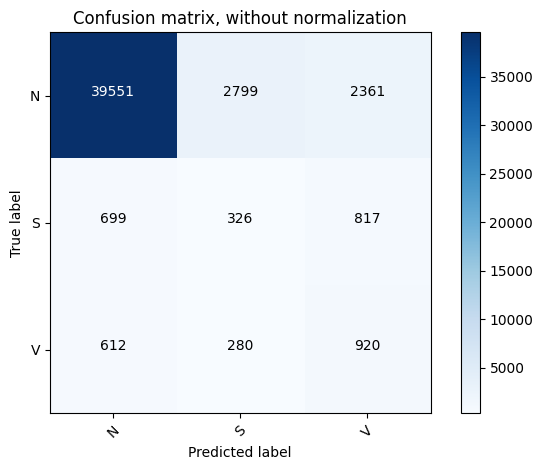

In [101]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# Define the plot_confusion_matrix function
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

# Plot confusion matrix for LSTM model
#lstm_predictions = lstm_model.predict(X_val)
#lstm_predictions_classes = np.argmax(lstm_predictions, axis=1)
#plot_confusion_matrix(np.argmax(y_val, axis=1), lstm_predictions_classes, classes=['N', 'S', 'V'])

# Plot confusion matrix for Bi-LSTM model
#bi_lstm_predictions = bi_lstm_model.predict(X_val)
#bi_lstm_predictions_classes = np.argmax(bi_lstm_predictions, axis=1)
#plot_confusion_matrix(np.argmax(y_val, axis=1), bi_lstm_predictions_classes, classes=['N', 'S', 'V'])

# Plot confusion matrix for 1D CNN model
cnn_predictions = cnn_model.predict(X_val)
cnn_predictions_classes = np.argmax(cnn_predictions, axis=1)
plot_confusion_matrix(np.argmax(y_val, axis=1), cnn_predictions_classes, classes=['N', 'S', 'V'])


In [102]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate

def create_mix_model(input_shape, output_shape):
    # Input layer for sequence data
    sequence_input = Input(shape=input_shape, name='sequence_input')

    # Layer 1: 1D Convolution
    conv1d_1 = Conv1D(filters=20, kernel_size=3, activation='relu', padding='valid')(sequence_input)

    # Layer 2: 1D Maxpooling
    maxpool_1 = MaxPooling1D(pool_size=2, strides=2)(conv1d_1)

    # Layer 3: 1D Convolution
    conv1d_2 = Conv1D(filters=6, kernel_size=10, activation='relu', padding='valid')(maxpool_1)

    # Layer 4: 1D Maxpooling
    maxpool_2 = MaxPooling1D(pool_size=2, strides=2)(conv1d_2)

    # Layer 5: 1D Convolution
    conv1d_3 = Conv1D(filters=6, kernel_size=5, activation='relu', padding='valid')(maxpool_2)

    # Layer 6: 1D Maxpooling
    maxpool_3 = MaxPooling1D(pool_size=2, strides=2)(conv1d_3)

    # Layer 7: LSTM
    lstm = LSTM(units=20, recurrent_dropout=0.2, dropout=0.2)(maxpool_3)

    # Output layer
    output = Dense(units=output_shape, activation='softmax')(lstm)

    # Model
    mix_model = Model(inputs=sequence_input, outputs=output)

    return mix_model

# Define input and output shapes based on your data
input_shape = (500, 1)  # Shape of sequence input
output_shape = 3        # Shape of output

# Create the model
mix_model = create_mix_model(input_shape, output_shape)

# Compile the model
mix_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
mix_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_input (InputLayer  [(None, 500, 1)]          0         
 )                                                               
                                                                 
 conv1d_15 (Conv1D)          (None, 498, 20)           80        
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 249, 20)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 240, 6)            1206      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 120, 6)            0         
 g1D)                                                            
                                                             

In [ ]:
# Define input and output shapes based on your data
input_shape = (500, 1)  # Shape of sequence input
output_shape = 3        # Shape of output

# Create the model
mix_model = create_mix_model(input_shape, output_shape)

# Compile the model before training
mix_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can fit the model to your training data
mix_model_history = mix_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
5014/5014 [==============================] - 1040s 206ms/step - loss: 0.7368 - accuracy: 0.6882 - val_loss: 0.4443 - val_accuracy: 0.8909
Epoch 2/10
 586/5014 [==>...........................] - ETA: 17:34 - loss: 0.6786 - accuracy: 0.7071

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming mix_model_history contains the training history

# Predict classes for validation set
y_pred = mix_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(output_shape)
plt.xticks(tick_marks, range(output_shape))
plt.yticks(tick_marks, range(output_shape))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))

# Show plot
plt.show()


In [ ]:
mix_model.save("/gdrive/My Drive/Applied_AI/")